# True Contacts

Description: work with true contact file to produce plots.

## Imports

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import Bio
Bio.__version__

'1.84'

In [3]:
from Bio.PDB import PDBParser
from Bio.PDB import PDBIO
from Bio.SeqUtils import seq1
import numpy as np
import os
import torch
import seaborn as sns
from matplotlib import pyplot as plt
import json

import sys
sys.path.append('..')
from utils.model_names import ESM_FOLD, ESM_CONTACT_HEAD
from utils.pdb import seq_from_structure, get_contacts_from_structure
from utils.esm_true_structure_inference import inference_from_pdb, precision_at_k, recall_at_k

## PDB File

### Import file

In [4]:
pdb_path = '../data/cadherin/pdb2o72.ent'

In [5]:
parser = PDBParser()
protein_structure = parser.get_structure('2O72', pdb_path)
protein_structure

<Structure id=2O72>

### Parse pdb into amino acid sequence

In [6]:
# abstracted to utils function
seq = seq_from_structure(protein_structure)
with open("../results/cadherin/meta_CADH1_HUMAN.json", "r") as f:
    start, end = json.load(f)["seq_range"]
seq = seq[start:end]
len(seq)

100

In [7]:
amino_acids = []

for residue in next(protein_structure.get_chains()):
    # remove heteroatoms
    het = residue.get_full_id()[3][0]
    if het == ' ':
        amino_acids.append(residue)

amino_acids = amino_acids[start:end]
len(amino_acids)

100

### Calculate pairwise distance between atoms

In [8]:
def min_residue_dist(res1, res2):
    res1_atoms = [a for a in res1.get_atoms()]
    res2_atoms = [a for a in res2.get_atoms()]

    min_dist = 1000
    for a_i in res1_atoms:
        for a_j in res2_atoms:
            min_dist = min(min_dist, np.linalg.norm(a_i - a_j))
    
    return min_dist

In [9]:
# d[i][j] = min euclidean dist between atoms in amino_acid[i] and atoms in amino_acid[j]
# i > j
pairwise_dists = {}

for i in range(len(amino_acids)):
    for j in range(i):
        #pairwise_dists[(i,j)] = np.linalg.norm(atom_coords[i] - atom_coords[j])
        pairwise_dists[(i,j)] = min_residue_dist(amino_acids[i], amino_acids[j])
        

import pickle
with open("../data/cadherin/PF00028_pairwise_dists.pkl", "wb") as file:
    pickle.dump(pairwise_dists, file, protocol=pickle.HIGHEST_PROTOCOL)
    file.close()

### Get contacts (protein pairs closer than a cutoff distance)

In [10]:
contact_dist_cutoff = 8.0
seq_separation_cutoff = 4
contacts = []

# NOTE: strictly i > j pairs
for i in range(len(amino_acids)):
    for j in range(i):
        if abs(i - j) > seq_separation_cutoff and pairwise_dists[(i,j)] <= contact_dist_cutoff:
            contacts.append((i, j))

contacts

[(8, 3),
 (9, 4),
 (12, 3),
 (12, 4),
 (12, 5),
 (12, 7),
 (13, 3),
 (13, 4),
 (13, 5),
 (13, 8),
 (14, 1),
 (14, 2),
 (14, 3),
 (14, 4),
 (14, 5),
 (14, 8),
 (14, 9),
 (15, 0),
 (15, 1),
 (15, 2),
 (15, 3),
 (15, 4),
 (16, 0),
 (16, 1),
 (16, 2),
 (17, 0),
 (17, 1),
 (18, 0),
 (19, 0),
 (28, 21),
 (28, 23),
 (29, 21),
 (29, 23),
 (29, 24),
 (30, 20),
 (30, 21),
 (30, 22),
 (30, 23),
 (30, 24),
 (30, 25),
 (31, 19),
 (31, 20),
 (31, 21),
 (31, 22),
 (31, 23),
 (31, 24),
 (31, 25),
 (31, 26),
 (32, 20),
 (32, 21),
 (32, 23),
 (32, 24),
 (32, 25),
 (33, 17),
 (33, 18),
 (33, 19),
 (33, 20),
 (33, 21),
 (33, 22),
 (33, 25),
 (34, 19),
 (34, 29),
 (35, 0),
 (35, 16),
 (35, 17),
 (35, 18),
 (35, 19),
 (35, 20),
 (35, 21),
 (36, 17),
 (37, 17),
 (43, 38),
 (45, 40),
 (46, 40),
 (46, 41),
 (47, 37),
 (47, 38),
 (47, 39),
 (47, 40),
 (47, 41),
 (47, 42),
 (48, 37),
 (48, 38),
 (48, 39),
 (48, 40),
 (48, 42),
 (48, 43),
 (49, 6),
 (49, 10),
 (49, 11),
 (49, 12),
 (49, 14),
 (49, 37),
 (49, 40),

In [11]:
# testing util function
assert contacts == get_contacts_from_structure(protein_structure)


AssertionError: 

In [12]:
real_contacts_path = os.path.join('..', 'data', 'cadherin', 'PF00028_real_contacts.csv')
np.savetxt(real_contacts_path, np.array(contacts), delimiter=",")

For the purposes of calculating the Top-L long-range precision score, we will treat these contacts as "ground truth".

## ESM inference on pdb sequence

### Some setup

In [13]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cuda'

### ESM-FOLD Output

In [24]:
# ESMFOLD inference on pdb structure
#esmfold_output = inference_from_pdb(ESM_FOLD, pdb_path, device)
esmfold_results_path = '/fs/nexus-scratch/vla/cadherin_esmfold.npz'
esmfold_output = np.load(esmfold_results_path)['arr_0']

In [25]:
# output should be LxL where L is the length of seq
assert esmfold_output.shape == (len(seq), len(seq))
np.save("../data/cadherin/PF00028_esmfold_output.npy", esmfold_output)

<Axes: >

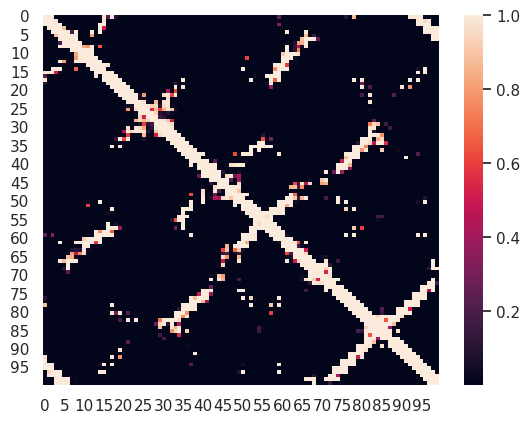

In [26]:
sns.set_theme()
sns.heatmap(esmfold_output)
#plt.savefig("../plots/PF00028/heatmaps/esmfold.png")

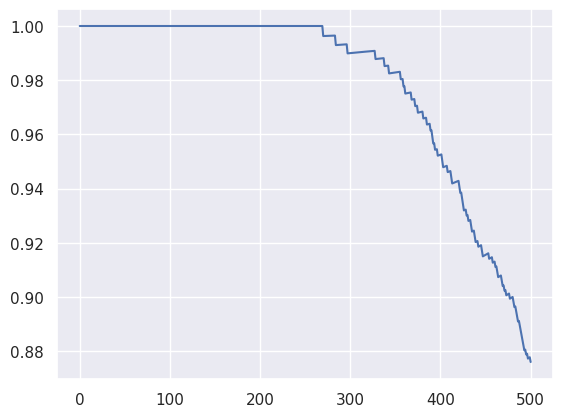

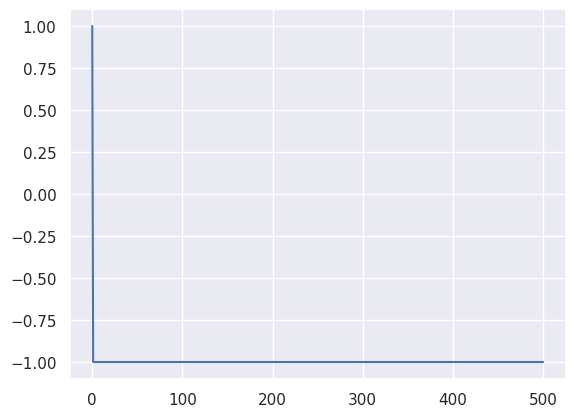

In [27]:
# precision @ L
esmfold_pl = np.ones([1+esmfold_output.shape[0] * 5])
esmfold_rl = np.ones_like(esmfold_pl)
for k in range(1, esmfold_pl.shape[0]):
    esmfold_pl[k]=precision_at_k(esmfold_output, contacts, k)
    esmfold_rl[k]=recall_at_k(esmfold_output, contacts, k)
np.save("../data/cadherin/PF00028_esmfold_pl.npy", esmfold_pl)
np.save("../data/cadherin/PF00028_esmfold_rl.npy", esmfold_rl)
esmfold_pl = np.load("../data/cadherin/PF00028_esmfold_pl.npy")
esmfold_rl = np.load("../data/cadherin/PF00028_esmfold_rl.npy")
sns.lineplot(esmfold_pl)
plt.savefig("../plots/PF00028/precision_l/esmfold.png")
plt.show()
sns.lineplot(esmfold_rl)
plt.savefig("../plots/PF00028/recall_l/esmfold.png")

### ESM-2 + Contact Head Output

In [28]:
#esm_contacthead_output = inference_from_pdb(ESM_CONTACT_HEAD, pdb_path, device)
#esm_contacthead_output = np.load("../data/cadherin/PF00028_esm_contacthead_output.npy")
esm_contacthead_output = np.load("../results/cadherin/cadherin_contacthead.npz")['arr_0']
esm_contacthead_output.shape

(100, 100)

In [29]:
# output should be LxL where L is the length of seq
assert esm_contacthead_output.shape == (len(seq), len(seq))
np.save("../data/cadherin/PF00028_esm_contacthead_output.npy", esm_contacthead_output)

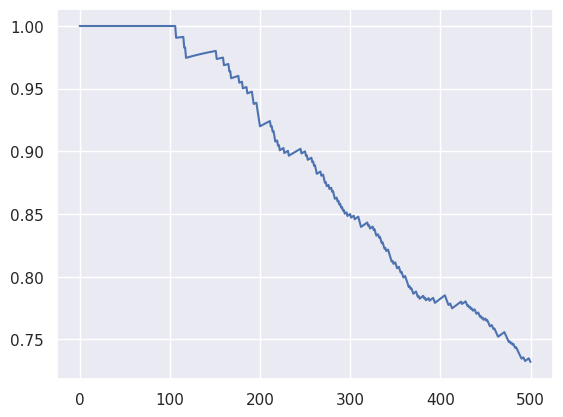

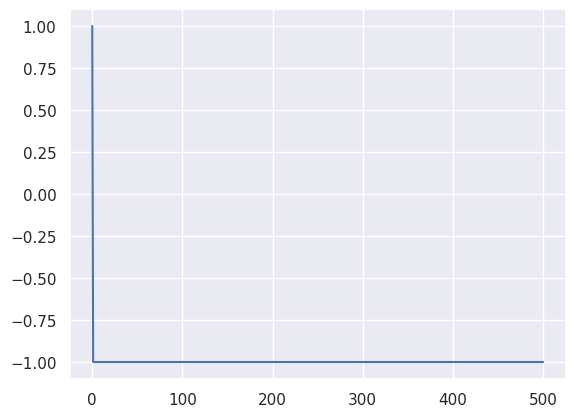

In [30]:
# precision @ L
esm_contacthead_pl = np.ones([1+esm_contacthead_output.shape[0] * 5])
esm_contacthead_rl = np.ones_like(esm_contacthead_pl)
for k in range(1, esm_contacthead_pl.shape[0]):
    esm_contacthead_pl[k]=precision_at_k(esm_contacthead_output, contacts, k)
    esm_contacthead_rl[k]=recall_at_k(esm_contacthead_output, contacts, k)
np.save("../data/cadherin/PF00028_esm_contacthead_pl.npy", esm_contacthead_pl)
np.save("../data/cadherin/PF00028_esm_contacthead_rl.npy", esm_contacthead_rl)
esm_contacthead_pl = np.load("../data/cadherin/PF00028_esm_contacthead_pl.npy")
esm_contacthead_rl = np.load("../data/cadherin/PF00028_esm_contacthead_rl.npy")
sns.lineplot(esm_contacthead_pl)
plt.savefig("../plots/PF00028/precision_l/esm_contact_head.png")
plt.show()
sns.lineplot(esm_contacthead_rl)
plt.savefig("../plots/PF00028/recall_l/esm_contact_head.png")

<Axes: >

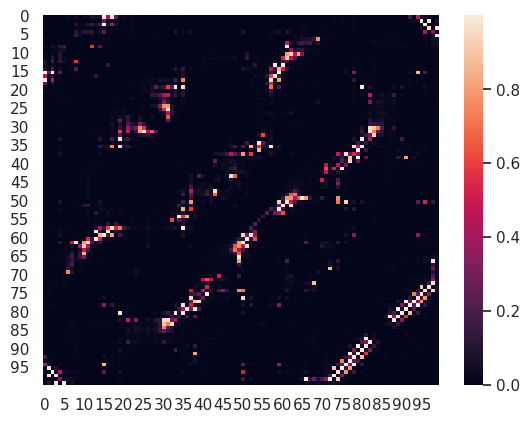

In [31]:
sns.set_theme()
sns.heatmap(esm_contacthead_output)
#plt.savefig("../plots/PF00028/heatmaps/esm_contact_head.png")

## Model Probabilities vs True Distances

In [32]:
pairwise_dists_and_esmfold_outputs = {}
for key in pairwise_dists:
    pairwise_dists_and_esmfold_outputs[key] = {}
    pairwise_dists_and_esmfold_outputs[key]["dist"] = pairwise_dists[key]
    pairwise_dists_and_esmfold_outputs[key]["score"] = esmfold_output[*key]
esmfold_dist_score = np.array([[pairwise_dists_and_esmfold_outputs[a]['dist'], pairwise_dists_and_esmfold_outputs[a]['score']] for a in pairwise_dists_and_esmfold_outputs])
pairwise_dists_and_esm_contacthead_outputs = {}
for key in pairwise_dists:
    pairwise_dists_and_esm_contacthead_outputs[key] = {}
    pairwise_dists_and_esm_contacthead_outputs[key]["dist"] = pairwise_dists[key]
    pairwise_dists_and_esm_contacthead_outputs[key]["score"] = esm_contacthead_output[*key]
esm_contacthead_dist_score = np.array([[pairwise_dists_and_esm_contacthead_outputs[a]['dist'], pairwise_dists_and_esm_contacthead_outputs[a]['score']] for a in pairwise_dists_and_esm_contacthead_outputs])

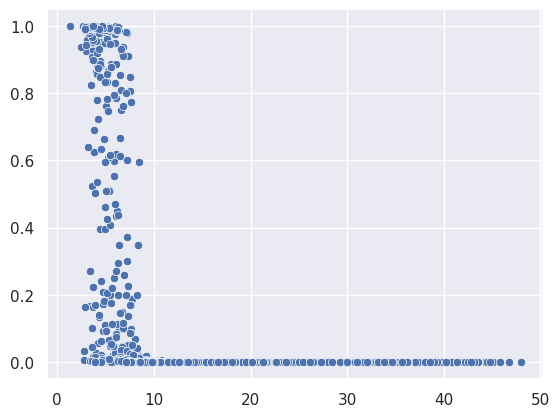

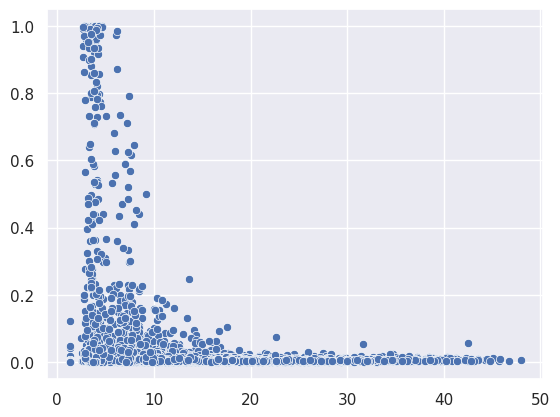

In [33]:
sns.scatterplot(x=esmfold_dist_score[:,0],y=esmfold_dist_score[:,1])
plt.savefig("../plots/PF00028/score_vs_distance/esmfold.png")
plt.show()
sns.scatterplot(x=esm_contacthead_dist_score[:,0],y=esm_contacthead_dist_score[:,1])
plt.savefig("../plots/PF00028/score_vs_distance/esm_contact_head.png")